In [ ]:
pip install pygam

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

In [16]:
# Load dataset
Organ2 = pd.read_csv("/Users/meghana/Desktop/STAT/STAT409/STAT409Project/Data/Organ2.csv")

In [4]:

# Add ID and reshape dataframe
Organ2['ID'] = np.arange(1, Organ2.shape[0] + 1)
Organ2_long = Organ2.melt(id_vars=['ID', 'isBourdon', 'cutUpHeight', 'diameterToe', 'acousticIntensity'], 
                          value_vars=[col for col in Organ2.columns if "Partial" in col],
                          var_name="name_p", value_name="partial_value")

# Split 'name_p' column
Organ2_long['type'] = Organ2_long['name_p'].str.split("Partial").str[0]
Organ2_long['partial_num'] = Organ2_long['name_p'].str.split("Partial").str[1].astype(float)



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


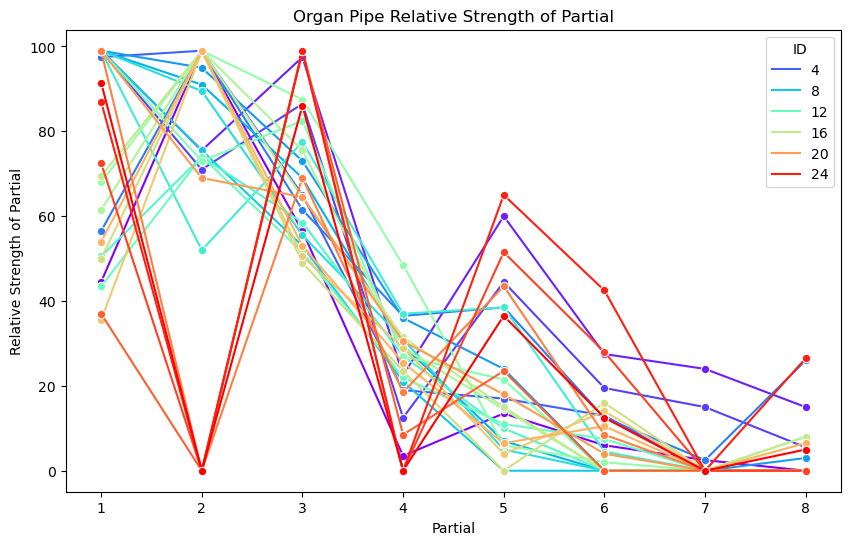

In [6]:
# Summarize data
summaryData = Organ2_long.groupby(['ID', 'partial_num', 'isBourdon', 'cutUpHeight', 'diameterToe', 'acousticIntensity'], 
                                  as_index=False)['partial_value'].mean()

# Plot data
plt.figure(figsize=(10,6))
sns.lineplot(data=summaryData, x='partial_num', y='partial_value', hue='ID', marker='o', palette='rainbow')
plt.xlabel('Partial')
plt.ylabel('Relative Strength of Partial')
plt.title('Organ Pipe Relative Strength of Partial')
plt.show()



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.7375
Link Function:                     IdentityLink Log Likelihood:                                 -1397.9694
Number of Samples:                          200 AIC:                                             2805.4139
                                                AICc:                                            2805.6937
                                                GCV:                                              447.6143
                                                Scale:                                            432.5831
                                                Pseudo R-Squared:                                    0.664
Feature Function                  Lam

/var/folders/f8/lp_yjvn94q3ft5xk_g5p3pb00000gp/T/ipykernel_13608/704730850.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(mod1.summary())


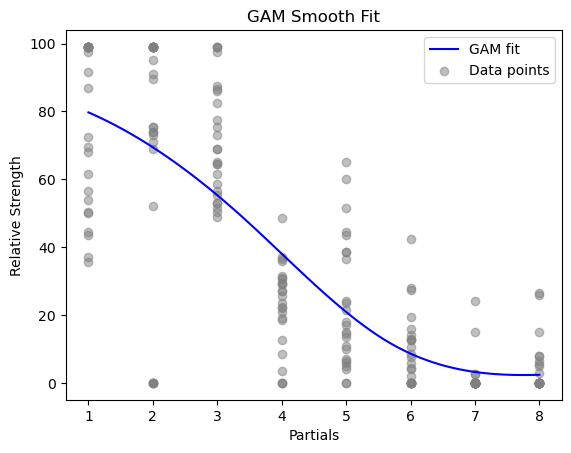

In [13]:
# GAM modeling
X = summaryData[['partial_num']].values
y = summaryData['partial_value'].values

mod1 = LinearGAM(s(0, n_splines=6)).fit(X, y)
print(mod1.summary())

# Plot GAM results
fig, ax = plt.subplots()
XX = mod1.generate_X_grid(term=0)
ax.plot(XX, mod1.predict(XX), color='blue', label='GAM fit')
ax.scatter(X, y, alpha=0.5, color='grey', label='Data points')
ax.set_xlabel('Partials')
ax.set_ylabel('Relative Strength')
ax.set_title('GAM Smooth Fit')
ax.legend()
plt.show()

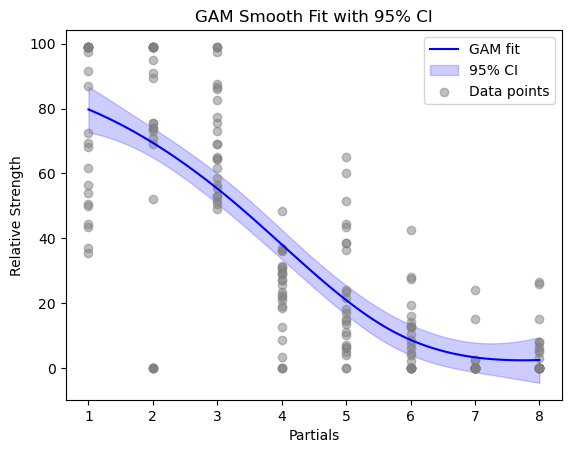

In [14]:
fig, ax = plt.subplots()

# Generate grid for predictions
XX = mod1.generate_X_grid(term=0)

# Predict GAM values and obtain standard errors for confidence intervals
predictions = mod1.predict(XX)
conf_intervals = mod1.confidence_intervals(XX, width=0.95)  # Adjust if your GAM package uses different syntax

# Extract lower and upper bounds of confidence intervals
lower_bound = conf_intervals[:, 0]
upper_bound = conf_intervals[:, 1]

# Plot the GAM fit line
ax.plot(XX, predictions, color='blue', label='GAM fit')

# Plot the confidence interval
ax.fill_between(XX.flatten(), lower_bound, upper_bound, color='blue', alpha=0.2, label='95% CI')

# Plot data points
ax.scatter(X, y, alpha=0.5, color='grey', label='Data points')

# Labels and titles
ax.set_xlabel('Partials')
ax.set_ylabel('Relative Strength')
ax.set_title('GAM Smooth Fit with 95% CI')
ax.legend()

plt.show()

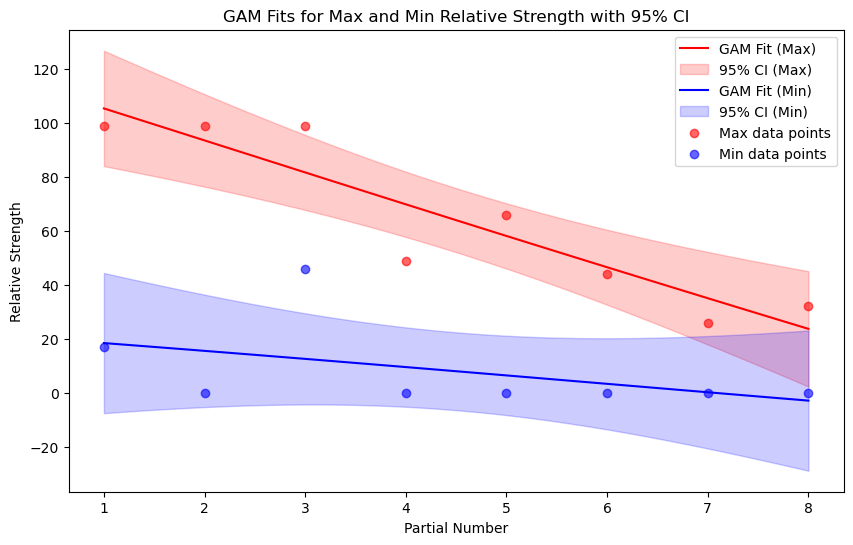

In [ ]:

# Load original dataset
organ_df = Organ2

# Add unique ID and reshape dataframe to long format
organ_df['ID'] = np.arange(1, organ_df.shape[0] + 1)
organ_long = organ_df.melt(id_vars=['ID', 'isBourdon', 'cutUpHeight', 'diameterToe', 'acousticIntensity'], 
                           value_vars=[col for col in organ_df.columns if "Partial" in col],
                           var_name="name_p", value_name="partial_value")

# Extract numeric partial number
organ_long['partial_num'] = organ_long['name_p'].str.extract(r'(\d+)').astype(float)

# Compute min and max instead of mean
max_data = organ_long.groupby(['partial_num'], as_index=False)['partial_value'].max()
min_data = organ_long.groupby(['partial_num'], as_index=False)['partial_value'].min()

# Merge max and min for analysis
summary_extremes = pd.merge(max_data, min_data, on='partial_num', suffixes=('_max', '_min'))

# Fit GAM for max values
X_max = summary_extremes[['partial_num']].values
y_max = summary_extremes['partial_value_max'].values
gam_max = LinearGAM(s(0, n_splines=6)).fit(X_max, y_max)

# Fit GAM for min values
y_min = summary_extremes['partial_value_min'].values
gam_min = LinearGAM(s(0, n_splines=6)).fit(X_max, y_min)

# Generate predictions and confidence intervals
XX = gam_max.generate_X_grid(term=0)

pred_max = gam_max.predict(XX)
conf_max = gam_max.confidence_intervals(XX, width=0.95)

pred_min = gam_min.predict(XX)
conf_min = gam_min.confidence_intervals(XX, width=0.95)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot GAM fits and confidence intervals for maximums
ax.plot(XX, pred_max, color='red', label='GAM Fit (Max)')
ax.fill_between(XX.flatten(), conf_max[:,0], conf_max[:,1], color='red', alpha=0.2, label='95% CI (Max)')

# Plot GAM fits and confidence intervals for minimums
ax.plot(XX, pred_min, color='blue', label='GAM Fit (Min)')
ax.fill_between(XX.flatten(), conf_min[:,0], conf_min[:,1], color='blue', alpha=0.2, label='95% CI (Min)')

# Scatter original max and min data
ax.scatter(X_max, y_max, color='red', alpha=0.6, label='Max data points')
ax.scatter(X_max, y_min, color='blue', alpha=0.6, label='Min data points')

ax.set_xlabel('Partial Number')
ax.set_ylabel('Relative Strength')
ax.set_title('GAM Fits for Max and Min Relative Strength with 95% CI')
ax.legend()

plt.show()


In [15]:
# Mixed Linear Model for Random Effects
summaryData['partial_num'] = summaryData['partial_num'].astype(float)
md = mixedlm("partial_value ~ partial_num", summaryData, groups=summaryData["ID"])
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: partial_value
No. Observations: 200     Method:             REML         
No. Groups:       25      Scale:              479.8049     
Min. group size:  8       Log-Likelihood:     -898.2418    
Max. group size:  8       Converged:          Yes          
Mean group size:  8.0                                      
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     89.855    3.414  26.323 0.000  83.165  96.545
partial_num  -12.253    0.676 -18.127 0.000 -13.578 -10.928
Group Var      0.000    1.168                              



/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
